In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

from src.generate import predict_single_mod, encode, predict_all
from src.dataset import get_validation_data
from src.config import cfg, load_cfg, set_cfg

import torch
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
from tqdm import tqdm
import random

In [2]:
model_path = "output/nl2bash/08-25_17:51:19"
model_name = "gpt2-medium"
device = "cuda"
load_cfg(model_path)
set_cfg('device', device)
set_cfg('beams', 3)


In [3]:
model = GPT2LMHeadModel.from_pretrained(model_path)
model.to(device)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [4]:
def post(nl, cm):
    dev_dict = {}
    for x, y in zip(cm, nl):
        if y not in dev_dict.keys():
            dev_dict[y] = [x]
        else:
            dev_dict[y].append(x)
    
    dev_dataset = zip(*dev_dict.items())
    return dev_dataset

In [5]:
def read_file(name, data_path="data/nl2bash/"):
    with open(data_path+name) as f:
        return [x.strip() for x in f.readlines()]
    
def save_file(name, content, data_path="data/nl2bash/"):
    content = "\n".join(content)
    #print(content)
    with open(data_path+name, 'w') as f:
        f.write(content)

nl = read_file('train_nl.txt')
cm = read_file('train_cm.txt')
train_nl, train_cm = post(nl, cm)


nl = read_file('test_nl.txt')
cm = read_file('test_cm.txt')
test_nl, test_cm = post(nl, cm)

nl = read_file('dev_nl.txt')
cm = read_file('dev_cm.txt')
dev_nl, dev_cm = post(nl, cm)


In [6]:
len(test_nl)

100

In [7]:
xx = set([x[0] for x in test_cm])
yy = set([x[0] for x in train_cm])
xx.intersection(yy)

{'$(dirname $(readlink -e ../../../../etc/passwd))',
 'cat file1 file2 ... file40000 | split -n r/1445 -d - outputprefix',
 'find  / -type d -iname "project.images" -ls',
 'find . -atime +30 -print',
 "find . -name '*.c' | xargs grep 'stdlib.h'",
 "find / -wholename  '/proc' -prune  -o  -type f -perm -0002 -exec ls -l {} \\;",
 'find /path -perm -022',
 'find /usr -newer /usr/FirstFile -print'}

In [8]:
query = "find all clojure files in the current directory"
predict_single_mod(model, tokenizer, query, beams=3)

('find . -name "*.clj"', tensor(0.9472))

In [9]:
pred_cm = []
for prompt in tqdm(dev_nl):
    r = predict_single_mod(model, tokenizer, prompt)
    pred_cm.append(r)

100%|██████████| 705/705 [08:15<00:00,  1.42it/s]


In [13]:
pred = [x[0] for x in pred_cm]
bl = [sentence_bleu(y,x) for y,x in zip(dev_cm, pred)]
np.mean(bl)
# blocked
# -3 0.5801870711429646
# -1 0.5667328591471584
# -8 0.5639580141162904


# interleaved
# -11 0.5812007820762158
# -2 0.5782041192465727
# -9 0.5680430641507556


0.5984327729200272

In [16]:
# met herhaling 0.5654881948617484

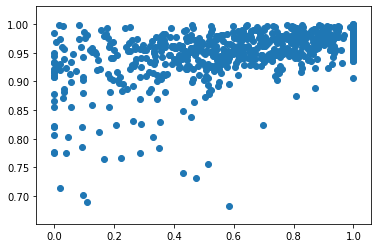

In [12]:

conf = [x[1] for x in pred_cm]
plt.scatter(bl, conf)

(array([ 53.,  31.,  35.,  51.,  75.,  87.,  80.,  77.,  96., 120.]),
 array([1.02449142e-231, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <a list of 10 Patch objects>)

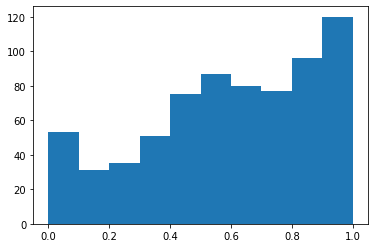

In [13]:
plt.hist(bl)

In [14]:
# these are the labels used for the manual evaluations
csv = pd.read_csv('../nl2bash/data/bash/manual_judgements/manual.evaluations.dev.samples.csv')
xx_nl = csv['description'][::21].values.tolist()
len(xx_nl)

100

(array([8.46e+03, 4.77e+02, 9.80e+01, 0.00e+00, 4.00e+01, 1.50e+01,
        0.00e+00, 3.00e+00, 0.00e+00, 3.00e+00]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

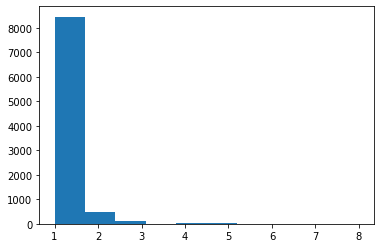

In [40]:
for i in train_cm:
    if len(i) == 1:
        continue

100

In [17]:
for prompt in xx_nl:
    print(prompt)
    resp = predict_single_mod(model, tokenizer, prompt, beams=3)
    print(resp[0])
    right = test_cm[test_nl.index(prompt)]
    for x in right:
        print(">", x)
    print(resp[1].item())
    if resp[0] in right:
        print("EC")
    else:
        print()
    
    
#set(xx_nl).intersection(set(train_nl))

Find all files in your home directory and below that are exactly 100M.
find ~ -size 100M
> find ~ -size 100M
0.9991397261619568
EC
Display the output of "ls" for an 80 character wide display
ls | less -S
> ls | column -c 80
0.907168447971344

Archive "_vimrc" to "~/.vimrc" suppressing non-error messages and compressing data during transmission
rsync -avz --exclude='error_log' _vimrc ~/Desktop/
> rsync -aqz _vimrc ~/.vimrc
0.9228045344352722

Print unique lines in sorted file "A" when compared to sorted files "B", "C", and "D"
comm -23 <(sort -u A) <(sort C) <(sort D)
> comm -2 -3 A B | comm -2 -3 - C | comm -2 -3 - D
0.9920392632484436

Delete all empty directories in minimum 2 levels down the root directory
find root -mindepth 2 -type d -empty -delete
> find root -mindepth 2 -type d -empty -delete
0.9962425827980042
EC
Find all Subscription.java files/directories under current directory and enter into the parent directory of the first one found
find . -name Subscription.java | xargs d

In [29]:
len(set(xx_nl).intersection(set(train_nl)))

81

In [20]:
def flt(l):
    return [x[0] for x in l]